# Project Data Literacy: Data Scientist Salaries

Dataset from: https://www.kaggle.com/jackogozaly/data-science-and-stem-salaries

US geodata: https://www.census.gov/cgi-bin/geo/shapefiles/index.php ('Select a layer type' -> ‘States and Equivalent’)

### Packages

In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import geopandas 
import seaborn as sns
from sklearn import preprocessing
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import warnings 
warnings.filterwarnings('ignore') 

### Data

In [21]:
data = pd.read_csv("Levels_Fyi_Salary_Data.csv", sep = ',', thousands = ',')
data.head()

timestamp    company level                         title  \
0   6/7/2017 11:33:27     Oracle    L3               Product Manager   
1  6/10/2017 17:11:29       eBay  SE 2             Software Engineer   
2  6/11/2017 14:53:57     Amazon    L7               Product Manager   
3   6/17/2017 0:23:14      Apple    M1  Software Engineering Manager   
4  6/20/2017 10:58:51  Microsoft    60             Software Engineer   

   totalyearlycompensation           location  yearsofexperience  \
0                   127000   Redwood City, CA                1.5   
1                   100000  San Francisco, CA                5.0   
2                   310000        Seattle, WA                8.0   
3                   372000      Sunnyvale, CA                7.0   
4                   157000  Mountain View, CA                5.0   

   yearsatcompany  tag  basesalary  ...  Doctorate_Degree  Highschool  \
0             1.5  NaN    107000.0  ...                 0           0   
1             3.0  NaN         0.0  ...                 0           0   
2             0.0  NaN    155000.0  ...                 0           0   
3             5.0  NaN    157000.0  ...                 0           0   
4             3.0  NaN         0.0  ...                 0           0   

  Some_College Race_Asian  Race_White  Race_Two_Or_More  Race_Black  \
0            0          0           0                 0           0   
1            0          0           0                 0           0   
2            0          0           0                 0           0   
3            0          0           0                 0           0   
4            0          0           0                 0           0   

   Race_Hispanic  Race  Education  
0              0   NaN        NaN  
1              0   NaN        NaN  
2              0   NaN        NaN  
3              0   NaN        NaN  
4              0   NaN        NaN  

[5 rows x 29 columns]

In [22]:
# Keep only 'Data Scientist' data for analysis
print(data.title.unique())
data = data[data['title'] == 'Data Scientist']

['Product Manager' 'Software Engineer' 'Software Engineering Manager'
 'Data Scientist' 'Solution Architect' 'Technical Program Manager'
 'Human Resources' 'Product Designer' 'Marketing' 'Business Analyst'
 'Hardware Engineer' 'Sales' 'Recruiter' 'Mechanical Engineer'
 'Management Consultant']


In [23]:
# Checking missing values
data.isnull().sum()

timestamp                     0
company                       0
level                         6
title                         0
totalyearlycompensation       0
location                      0
yearsofexperience             0
yearsatcompany                0
tag                           5
basesalary                    0
stockgrantvalue               0
bonus                         0
gender                      838
otherdetails                763
cityid                        0
dmaid                         0
rowNumber                     0
Masters_Degree                0
Bachelors_Degree              0
Doctorate_Degree              0
Highschool                    0
Some_College                  0
Race_Asian                    0
Race_White                    0
Race_Two_Or_More              0
Race_Black                    0
Race_Hispanic                 0
Race                       1683
Education                  1168
dtype: int64

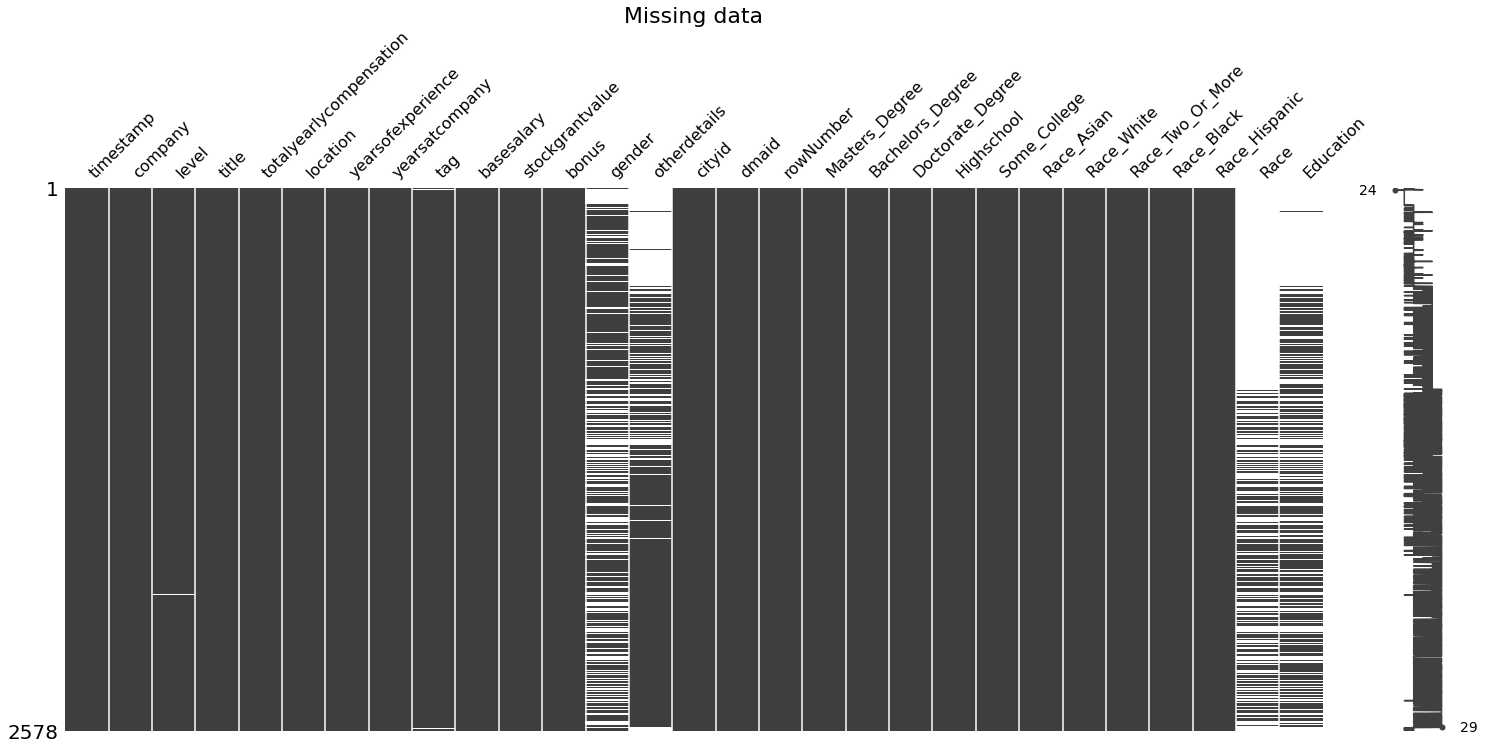

In [24]:
msno.matrix(data)
plt.title("Missing data", fontsize=22)
plt.show()

In [25]:
data.shape

(2578, 29)

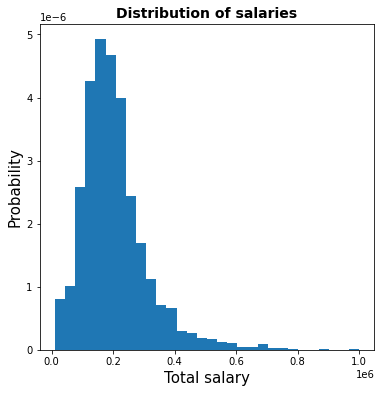

In [26]:
plt.figure(figsize=(6,6))
plt.hist(data['totalyearlycompensation'], density = True ,bins=30)
plt.xlabel('Total salary', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.title('Distribution of salaries', fontweight='bold', fontsize=14)
plt.show()

### Data Cleaning

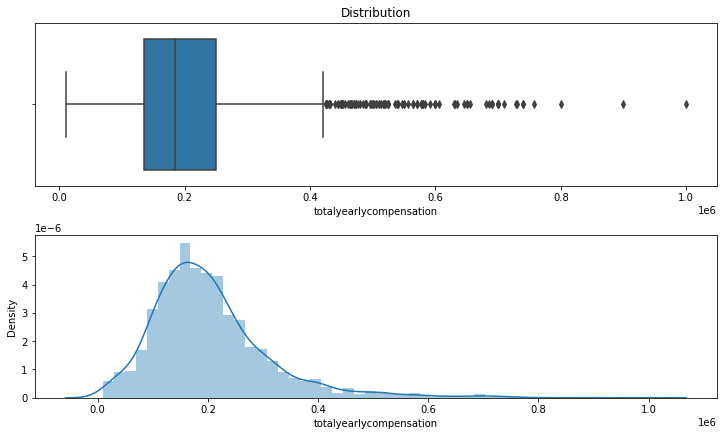

In [27]:
# Creating box and distribution plots
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
sns.boxplot(data['totalyearlycompensation'], ax=ax1).set(title='Distribution')
sns.distplot(data['totalyearlycompensation'], ax=ax2)
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=0.7)

In [28]:
# Weeding out the outliers
data = data[data['totalyearlycompensation'].between(data['totalyearlycompensation'].quantile(.05),\
                                                    data['totalyearlycompensation'].quantile(.95))]

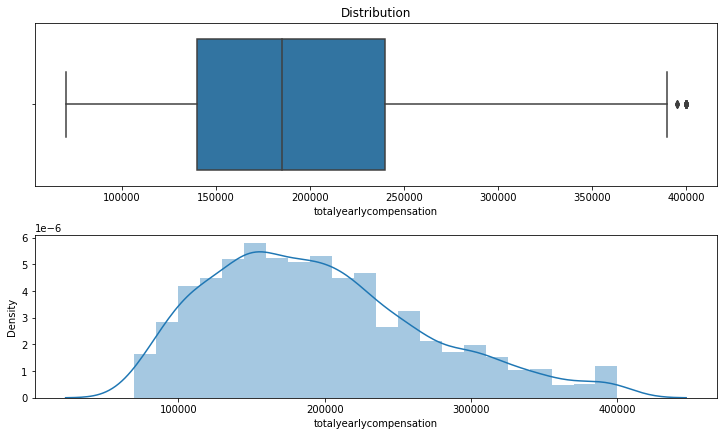

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
sns.boxplot(data['totalyearlycompensation'], ax=ax1).set(title='Distribution')
sns.distplot(data['totalyearlycompensation'], ax=ax2)
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=0.7)

In [30]:
# data size after removing outliers
data.shape

(2325, 29)

In [31]:
# filling the missing data as 'Not Given'
data.level = data.level.fillna('Not Given')
data.tag = data.tag.fillna('Not Given')
data.gender = data.gender.fillna('Not Given')
data.otherdetails = data.otherdetails.fillna('Not Given')
data.Race = data.Race.fillna('Not Given')
data.Education = data.Education.fillna('Not Given')

In [32]:
print(len(data.location.unique()))

204


In [33]:
print(data.gender.unique())

['Male' 'Female' 'Not Given' 'Other']


In [34]:
# renaming
data.rename(columns={'Race':'Ethnicity'}, inplace= True)
data.Ethnicity.unique()

array(['Not Given', 'Black', 'White', 'Asian', 'Two Or More', 'Hispanic'],
      dtype=object)

In [35]:
print(data.Education.unique())

['Not Given' 'PhD' "Master's Degree" "Bachelor's Degree" 'Highschool'
 'Some College']


In [36]:
data[data['basesalary'] == 0]

timestamp          company                       level  \
444     6/8/2018 17:55:09             ebay                          26   
673     8/4/2018 20:22:00           Amazon                          L4   
794     8/15/2018 6:10:00           Amazon                           L   
1014   8/27/2018 12:34:51        Microsoft                          62   
1477    9/27/2018 2:58:43           Amazon                           5   
...                   ...              ...                         ...   
10491   9/7/2019 18:34:27           target                          l6   
10542   9/9/2019 13:52:40  Electronic Arts                          L5   
10543   9/9/2019 14:56:15           Reddit                         IC3   
10776   9/14/2019 2:01:10         Autodesk  Senior Software Engineer 2   
10851  9/14/2019 17:32:41        Microsoft                Principal EM   

                title  totalyearlycompensation           location  \
444    Data Scientist                   180000       San Jose, CA   
673    Data Scientist                   130000        Seattle, WA   
794    Data Scientist                   200000         Boston, MA   
1014   Data Scientist                   149000        Redmond, WA   
1477   Data Scientist                   115000        Seattle, WA   
...               ...                      ...                ...   
10491  Data Scientist                   200000      Sunnyvale, CA   
10542  Data Scientist                   160000   Redwood City, CA   
10543  Data Scientist                   142000  San Francisco, CA   
10776  Data Scientist                   149000  San Francisco, CA   
10851  Data Scientist                   147000        Seattle, WA   

       yearsofexperience  yearsatcompany               tag  basesalary  ...  \
444                 10.0             5.0         Not Given         0.0  ...   
673                  7.0             1.0           ML / AI         0.0  ...   
794                  5.0             1.0  Machine Learning         0.0  ...   
1014                 9.0             1.0           ML / AI         0.0  ...   
1477                 6.0             2.0           ML / AI         0.0  ...   
...                  ...             ...               ...         ...  ...   
10491                7.0             3.0           ML / AI         0.0  ...   
10542                5.0             2.0           ML / AI         0.0  ...   
10543                3.0             2.0           ML / AI         0.0  ...   
10776                1.0             0.5           ML / AI         0.0  ...   
10851                7.0             4.0            DevOps         0.0  ...   

       Doctorate_Degree  Highschool Some_College Race_Asian  Race_White  \
444                   0           0            0          0           0   
673                   0           0            0          0           0   
794                   0           0            0          0           0   
1014                  0           0            0          0           0   
1477                  0           0            0          0           0   
...                 ...         ...          ...        ...         ...   
10491                 0           0            0          0           0   
10542                 0           0            0          0           0   
10543                 0           0            0          0           0   
10776                 0           0            0          0           0   
10851                 0           0            0          0           0   

       Race_Two_Or_More  Race_Black  Race_Hispanic  Ethnicity  Education  
444                   0           0              0  Not Given  Not Given  
673                   0           0              0  Not Given  Not Given  
794                   0           0              0  Not Given  Not Given  
1014                  0           0              0  Not Given  Not Given  
1477                  0           0              0  Not Given  Not Given 

In [37]:
#replacing zero entries with mean of 'basesalary'
data['basesalary'].replace(0, np.mean(data[data['basesalary']!=0].basesalary), inplace=True)

In [38]:
data.describe()

totalyearlycompensation  yearsofexperience  yearsatcompany  \
count              2325.000000        2325.000000     2325.000000   
mean             194971.612903           4.909247        2.032194   
std               73757.271955           4.006119        2.261548   
min               70000.000000           0.000000        0.000000   
25%              140000.000000           2.000000        0.250000   
50%              185000.000000           4.000000        2.000000   
75%              240000.000000           7.000000        3.000000   
max              400000.000000          34.000000       20.000000   

          basesalary  stockgrantvalue          bonus        cityid  \
count    2325.000000      2325.000000    2325.000000   2325.000000   
mean   142487.673689     33936.344086   17219.784946   9830.107097   
std     37512.484503     40755.222989   18279.182806   5842.936440   
min     30000.000000         0.000000       0.000000   1182.000000   
25%    120000.000000         0.000000    4000.000000   7419.000000   
50%    142487.673689     20000.000000   15000.000000   8198.000000   
75%    160000.000000     50000.000000   25000.000000  11470.000000   
max    400000.000000    250000.000000  200000.000000  47926.000000   

             dmaid     rowNumber  Masters_Degree  Bachelors_Degree  \
count  2325.000000   2325.000000     2325.000000       2325.000000   
mean    644.356989  42768.189677        0.311828          0.085591   
std     249.973186  24514.555763        0.463340          0.279820   
min       0.000000    813.000000        0.000000          0.000000   
25%     506.000000  21670.000000        0.000000          0.000000   
50%     807.000000  43107.000000        0.000000          0.000000   
75%     807.000000  65078.000000        1.000000          0.000000   
max     862.000000  83867.000000        1.000000          1.000000   

       Doctorate_Degree   Highschool  Some_College   Race_Asian   Race_White  \
count       2325.000000  2325.000000   2325.000000  2325.000000  2325.000000   
mean           0.145806     0.001290      0.000430     0.192258     0.116989   
std            0.352988     0.035906      0.020739     0.394160     0.321477   
min            0.000000     0.000000      0.000000     0.000000     0.000000   
25%            0.000000     0.000000      0.000000     0.000000     0.000000   
50%            0.000000     0.000000      0.000000     0.000000     0.000000   
75%            0.000000     0.000000      0.000000     0.000000     0.000000   
max            1.000000     1.000000      1.000000     1.000000     1.000000   

       Race_Two_Or_More   Race_Black  Race_Hispanic  
count       2325.000000  2325.000000    2325.000000  
mean           0.010753     0.005591       0.012903  
std            0.103158     0.074582       0.112881  
min            0.000000     0.000000       0.000000  
25%            0.000000     0.000000       0.000000  
50%            0.000000     0.000000       0.000000  
75%            0.000000     0.000000       0.000000  
max            1.000000     1.000000       1.000000

### Visualizations

In [39]:
# Grouping by company salaries
data_comp = pd.DataFrame(data.groupby('company').mean()['totalyearlycompensation'])
data_comp = data_comp.sort_values(by='totalyearlycompensation',ascending=False)
data_comp_50 = data_comp[['totalyearlycompensation']][:50]
data_comp_50.head()

totalyearlycompensation
company                           
Citadel              400000.000000
Zoom                 400000.000000
JP Morgan            400000.000000
Netflix              391444.444444
Deliveroo            382000.000000

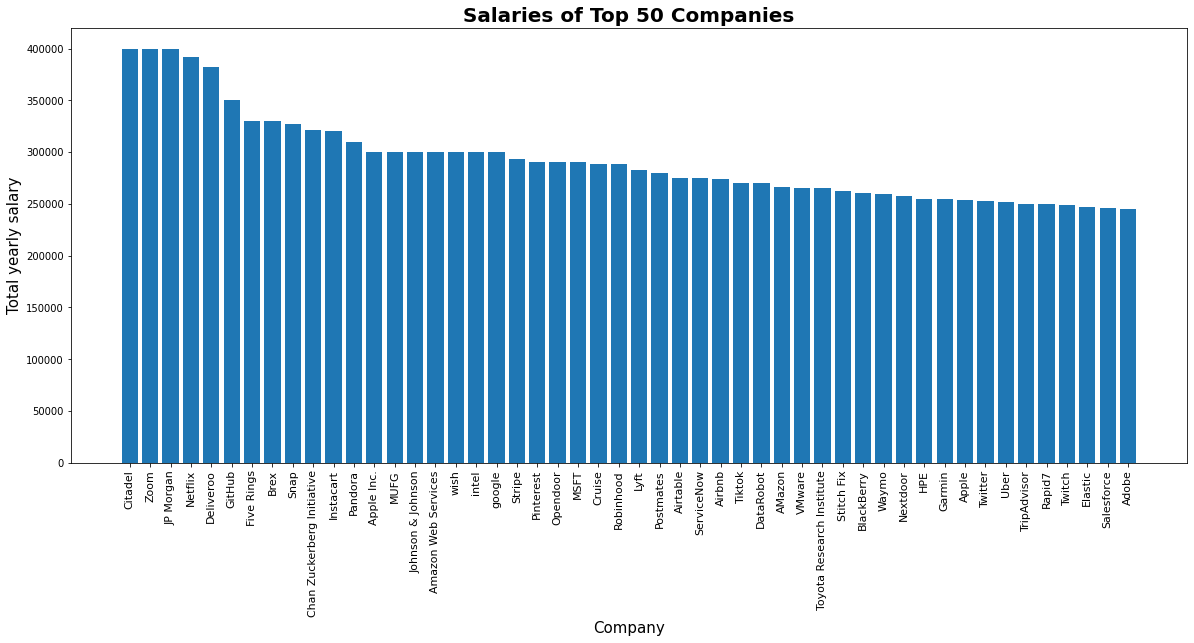

In [40]:
plt.figure(figsize=(20,8))
plt.bar(data_comp_50.index, data_comp_50['totalyearlycompensation'])
plt.xticks(rotation='vertical', size=11)
plt.xlabel('Company', fontsize=15)
plt.ylabel('Total yearly salary', fontsize=15)
plt.title('Salaries of Top 50 Companies', fontweight='bold', fontsize=20)
plt.show()

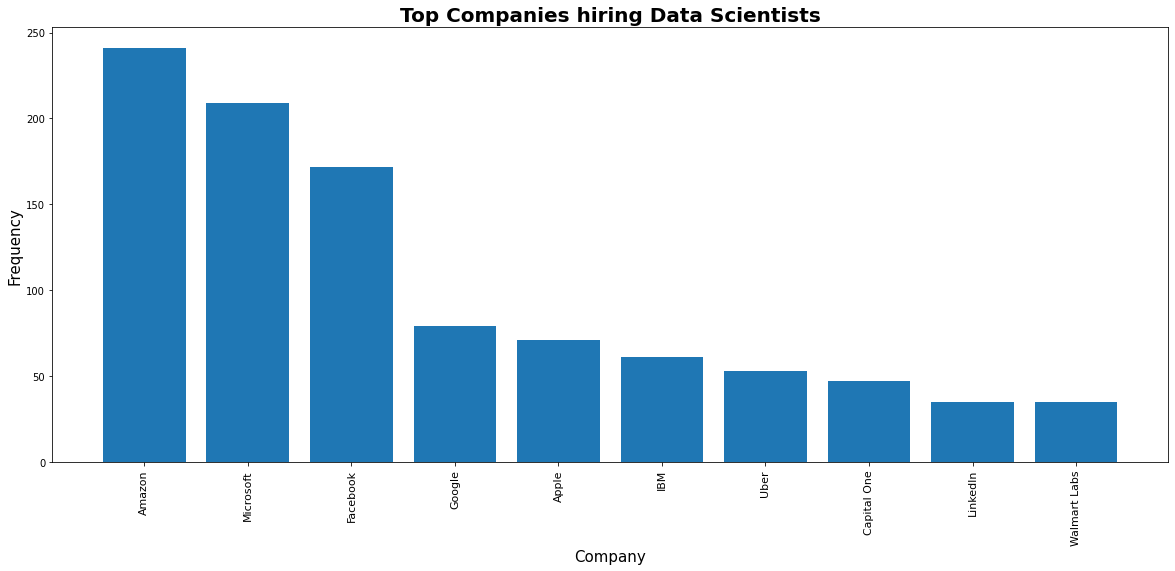

In [41]:
# Absolute number of Data Scientists in the company
data_top_hire = data.groupby('company').size().reset_index(name='counts')
data_top_hire = data_top_hire.sort_values(by='counts',ascending=False)
data_top_hire = data_top_hire[['company','counts']][:10]

plt.figure(figsize=(20,8))
plt.bar(data_top_hire.company, data_top_hire['counts'])
plt.xticks(rotation='vertical', size=11)
plt.xlabel('Company', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Top Companies hiring Data Scientists', fontweight='bold', fontsize=20)
plt.show()

In [42]:
# Grouping by ethnicity
data_ethnicity = pd.DataFrame(data.groupby('Ethnicity').mean()['totalyearlycompensation'])
data_ethnicity

totalyearlycompensation
Ethnicity                           
Asian                  195353.467562
Black                  162615.384615
Hispanic               180000.000000
Not Given              198024.057217
Two Or More            177840.000000
White                  181856.617647

In [43]:
fig = go.Figure()
fig = fig.add_trace(
                        go.Pie(labels=data['Ethnicity'].
                           value_counts().index, 
                           values=data['Ethnicity'].
                           value_counts().values,
                        hoverinfo='label+percent',
                        textinfo='percent',
                        hole=0.6)
                   )

fig.update_layout(
    title=dict(text='<b>Ethnicity in Data Science jobs<b>', x=0.5),
    plot_bgcolor='white'
)

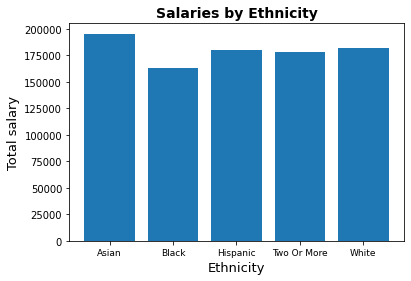

In [46]:
data_ethnicity = data_ethnicity[data_ethnicity.index != 'Not Given']
plt.bar(data_ethnicity.index, data_ethnicity['totalyearlycompensation'])
plt.xticks(fontsize=9)
plt.xlabel('Ethnicity', fontsize=13)
plt.ylabel('Total salary', fontsize=13)
plt.title('Salaries by Ethnicity', fontweight='bold', fontsize=14)
plt.show()

In [45]:
# Gender Distribution in Data Science jobs
fig = go.Figure()
fig = fig.add_trace(
                        go.Pie(labels=data['gender'].
                           value_counts().index, 
                           values=data['gender'].
                           value_counts().values,
                        hoverinfo='label+percent',
                        textinfo='percent',
                        hole=0.6)
                   )

fig.update_layout(
    title=dict(text='<b>Gender in Data Science jobs<b>', x=0.5),
    plot_bgcolor='white'
)

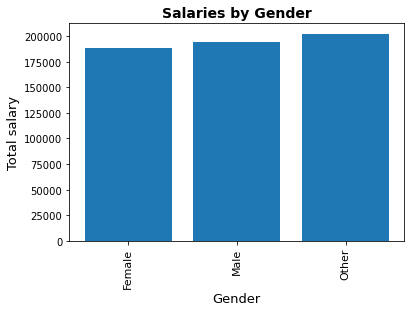

In [26]:
# Salary by Gender
data_gender = pd.DataFrame(data.groupby('gender').mean()['totalyearlycompensation'])
data_gender = data_gender[data_gender.index != 'Not Given']
plt.bar(data_gender.index, data_gender['totalyearlycompensation'])
plt.xlabel('Gender', fontsize=13)
plt.ylabel('Total salary', fontsize=13)
plt.xticks(rotation='vertical', size=11)
plt.title('Salaries by Gender', fontweight='bold', fontsize=14)
plt.show()

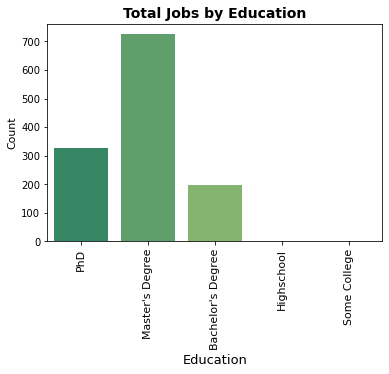

In [27]:
sns.countplot(data.Education[data['Education']!= 'Not Given'], palette='summer')
plt.xlabel('Education', fontsize=13)
plt.xticks(rotation='vertical', size=11)
plt.ylabel('Count', fontsize=11)
plt.title('Total Jobs by Education', fontweight='bold', fontsize=14)
plt.show()

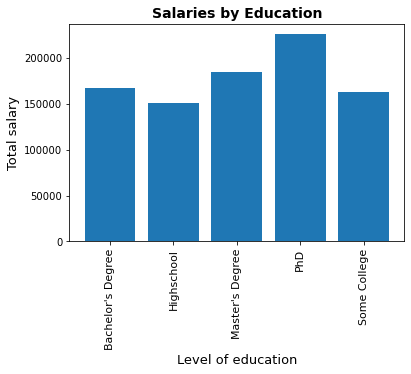

In [28]:
data_edu = pd.DataFrame(data.groupby('Education').mean()['totalyearlycompensation'])
data_edu = data_edu[data_edu.index != 'Not Given']
plt.bar(data_edu.index, data_edu['totalyearlycompensation'])
plt.xlabel('Level of education', fontsize=13)
plt.ylabel('Total salary', fontsize=13)
plt.xticks(rotation='vertical', size=11)
plt.title('Salaries by Education', fontweight='bold', fontsize=14)
plt.show()

### Choropleth Maps

#### US Map

In [29]:
# Get list of US state codes
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

In [30]:
data_usa = data[data['location'].str.contains('|'.join(states), case=True)]
data_usa
data_usa.location.unique()

array(['San Francisco, CA', 'Seattle, WA', 'San Jose, CA', 'Bellevue, WA',
       'Palo Alto, CA', 'New York, NY', 'Menlo Park, CA', 'San Diego, CA',
       'Mc Lean, VA', 'Boston, MA', 'Washington, DC', 'Redmond, WA',
       'Mountain View, CA', 'Cupertino, CA', 'Sunnyvale, CA',
       'Los Gatos, CA', 'Bloomington, MN', 'Amsterdam, NH, Netherlands',
       'Austin, TX', 'Santa Monica, CA', 'Charlotte, NC', 'Dallas, TX',
       'Albuquerque, NM', 'Cary, NC', 'Atlanta, GA', 'Cambridge, MA',
       'Bentonville, AR', 'Irvine, CA', 'Los Angeles, CA', 'Chicago, IL',
       'Broomfield, CO', 'Hillsboro, OR', 'Santa Clara, CA', 'Plano, TX',
       'Columbus, OH', 'Colorado Springs, CO', 'Portland, OR',
       'Berkeley, CA', 'Morrisville, NC', 'Boulder, CO', 'Richmond, VA',
       'Pittsburgh, PA', 'Raleigh, NC', 'Reston, VA', 'Wilmington, DE',
       'Houston, TX', 'Redwood City, CA', 'Denver, CO',
       'Walnut Creek, CA', 'Farmington, UT', 'Fremont, CA',
       'Cincinnati, OH', 'Phoeni

In [31]:
data_usa[['City', 'State']] = data_usa['location'].str.split(', ', 1, expand = True)

In [32]:
data_usa.State.unique()

array(['CA', 'WA', 'NY', 'VA', 'MA', 'DC', 'MN', 'NH, Netherlands', 'TX',
       'NC', 'NM', 'GA', 'AR', 'IL', 'CO', 'OR', 'OH', 'PA', 'DE', 'UT',
       'AZ', 'NJ', 'MI', 'WI', 'MO', 'CT', 'FL', 'ID', 'TN',
       'SC, United Kingdom', 'KS', 'RI', 'IN', 'KY', 'IL, France',
       'HK, Hong Kong (SAR)', 'SC', 'MD', 'NV', 'AL', 'CT, Spain', 'OK',
       'CT, Australia', 'MS'], dtype=object)

In [33]:
data_usa.shape

(2114, 31)

In [34]:
# get rid of misplaced data
misplaced = ['NH, Netherlands', 'SC, United Kingdom', 'IL, France', 'HK, Hong Kong', 'CT, Spain', 'CT, Australia']
data_misplaced = data_usa[data_usa['State'].str.contains('|'.join(misplaced))]
data_usa = data_usa[~data_usa.State.isin(data_misplaced.State)]
data_usa['State'].unique()

array(['CA', 'WA', 'NY', 'VA', 'MA', 'DC', 'MN', 'TX', 'NC', 'NM', 'GA',
       'AR', 'IL', 'CO', 'OR', 'OH', 'PA', 'DE', 'UT', 'AZ', 'NJ', 'MI',
       'WI', 'MO', 'CT', 'FL', 'ID', 'TN', 'KS', 'RI', 'IN', 'KY', 'SC',
       'MD', 'NV', 'AL', 'OK', 'MS'], dtype=object)

In [35]:
data_usa = data_usa.reset_index(drop=True)
data_usa.head()

timestamp    company   level           title  \
0   6/5/2018 14:06:30   LinkedIn  Senior  Data Scientist   
1    6/8/2018 9:49:25  Microsoft      64  Data Scientist   
2   6/8/2018 17:55:09       ebay      26  Data Scientist   
3  6/17/2018 11:39:38   Facebook       5  Data Scientist   
4  6/17/2018 19:02:50     Amazon      L5  Data Scientist   

   totalyearlycompensation           location  yearsofexperience  \
0                   233000  San Francisco, CA                4.0   
1                   218000        Seattle, WA               11.0   
2                   180000       San Jose, CA               10.0   
3                   370000        Seattle, WA                8.0   
4                   200000        Seattle, WA                3.0   

   yearsatcompany            tag     basesalary  ...  Some_College  \
0             0.0  Data Analysis  162000.000000  ...             0   
1            11.0        ML / AI  165000.000000  ...             0   
2             5.0      Not Given  142487.673689  ...             0   
3             3.0      Not Given  190000.000000  ...             0   
4             0.0        ML / AI  150000.000000  ...             0   

   Race_Asian Race_White Race_Two_Or_More  Race_Black  Race_Hispanic  \
0           0          0                0           0              0   
1           0          0                0           0              0   
2           0          0                0           0              0   
3           0          0                0           0              0   
4           0          0                0           0              0   

   Ethnicity  Education           City  State  
0  Not Given  Not Given  San Francisco     CA  
1  Not Given  Not Given        Seattle     WA  
2  Not Given  Not Given       San Jose     CA  
3  Not Given  Not Given        Seattle     WA  
4  Not Given  Not Given        Seattle     WA  

[5 rows x 31 columns]

In [36]:
# download dataset before running the code
df = geopandas.read_file('tl_2021_us_state.shp')

In [37]:
# merge data sets
data_usa_loc = df.merge(data_usa, how="left", left_on="STUSPS", right_on="State")
data_usa_loc

REGION DIVISION STATEFP   STATENS GEOID STUSPS           NAME LSAD  \
0         3        5      54  01779805    54     WV  West Virginia   00   
1         3        5      12  00294478    12     FL        Florida   00   
2         3        5      12  00294478    12     FL        Florida   00   
3         3        5      12  00294478    12     FL        Florida   00   
4         3        5      12  00294478    12     FL        Florida   00   
...     ...      ...     ...       ...   ...    ...            ...  ...   
2104      4        8      04  01779777    04     AZ        Arizona   00   
2105      4        8      04  01779777    04     AZ        Arizona   00   
2106      4        8      04  01779777    04     AZ        Arizona   00   
2107      4        8      04  01779777    04     AZ        Arizona   00   
2108      4        8      04  01779777    04     AZ        Arizona   00   

      MTFCC FUNCSTAT  ...  Some_College  Race_Asian Race_White  \
0     G4000        A  ...           NaN         NaN        NaN   
1     G4000        A  ...           0.0         0.0        0.0   
2     G4000        A  ...           0.0         0.0        0.0   
3     G4000        A  ...           0.0         0.0        0.0   
4     G4000        A  ...           0.0         0.0        0.0   
...     ...      ...  ...           ...         ...        ...   
2104  G4000        A  ...           0.0         0.0        1.0   
2105  G4000        A  ...           0.0         1.0        0.0   
2106  G4000        A  ...           0.0         0.0        0.0   
2107  G4000        A  ...           0.0         0.0        0.0   
2108  G4000        A  ...           0.0         0.0        1.0   

     Race_Two_Or_More Race_Black Race_Hispanic    Ethnicity  \
0                 NaN        NaN           NaN          NaN   
1                 0.0        0.0           0.0    Not Given   
2                 0.0        0.0           0.0    Not Given   
3                 0.0        0.0           0.0    Not Given   
4                 0.0        0.0           0.0    Not Given   
...               ...        ...           ...          ...   
2104              0.0        0.0           0.0        White   
2105              0.0        0.0           0.0        Asian   
2106              1.0        0.0           0.0  Two Or More   
2107              0.0        0.0           0.0    Not Given   
2108              0.0        0.0           0.0        White   

              Education         City  State  
0                   NaN          NaN    NaN  
1                   PhD  Gainesville     FL  
2                   PhD        Miami     FL  
3       Master's Degree      Orlando     FL  
4     Bachelor's Degree        Tampa     FL  
...                 ...          ...    ...  
2104  Bachelor's Degree      Phoenix     AZ  
2105    Master's Degree     Chandler     AZ  
2106    Master's Degree      Phoenix     AZ  
2107    Master's Degree      Phoenix     AZ  
2108    Master's Degree      Phoenix     AZ  

[2109 rows x 46 columns]

In [38]:
#reduce data frame
data_usa_loc = data_usa_loc[['STUSPS','totalyearlycompensation',
       'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary',
       'stockgrantvalue', 'bonus','geometry']]
data_usa_loc.columns

Index(['STUSPS', 'totalyearlycompensation', 'location', 'yearsofexperience',
       'yearsatcompany', 'tag', 'basesalary', 'stockgrantvalue', 'bonus',
       'geometry'],
      dtype='object')

In [39]:
print(data_usa_loc.STUSPS.unique())
print(len(data_usa_loc.STUSPS.unique()))

['WV' 'FL' 'IL' 'MN' 'MD' 'RI' 'ID' 'NH' 'NC' 'VT' 'CT' 'DE' 'NM' 'CA'
 'NJ' 'WI' 'OR' 'NE' 'PA' 'WA' 'LA' 'GA' 'AL' 'UT' 'OH' 'TX' 'CO' 'SC'
 'OK' 'TN' 'WY' 'HI' 'ND' 'KY' 'VI' 'MP' 'GU' 'ME' 'NY' 'NV' 'AK' 'AS'
 'MI' 'AR' 'MS' 'MO' 'MT' 'KS' 'IN' 'PR' 'SD' 'MA' 'VA' 'DC' 'IA' 'AZ']
56


In [40]:
states_loc = data_usa_loc.STUSPS.unique()
states_loc

array(['WV', 'FL', 'IL', 'MN', 'MD', 'RI', 'ID', 'NH', 'NC', 'VT', 'CT',
       'DE', 'NM', 'CA', 'NJ', 'WI', 'OR', 'NE', 'PA', 'WA', 'LA', 'GA',
       'AL', 'UT', 'OH', 'TX', 'CO', 'SC', 'OK', 'TN', 'WY', 'HI', 'ND',
       'KY', 'VI', 'MP', 'GU', 'ME', 'NY', 'NV', 'AK', 'AS', 'MI', 'AR',
       'MS', 'MO', 'MT', 'KS', 'IN', 'PR', 'SD', 'MA', 'VA', 'DC', 'IA',
       'AZ'], dtype=object)

In [41]:
#check which additional (wrong) state codes need to be deleted
states_na =  set(states_loc)- set(states)
states_na

{'AS', 'GU', 'MP', 'PR', 'VI'}

In [42]:
# delete wrong states
list_wrong_states = ['AS', 'GU', 'MP', 'PR', 'VI','AK', 'HI' ] # also delete Alaska and Hawaii 'AK', 'HI'
data_usa_loc =(data_usa_loc[data_usa_loc.STUSPS.isin(list_wrong_states) == False])

In [43]:
len(data_usa_loc.STUSPS.unique())

49

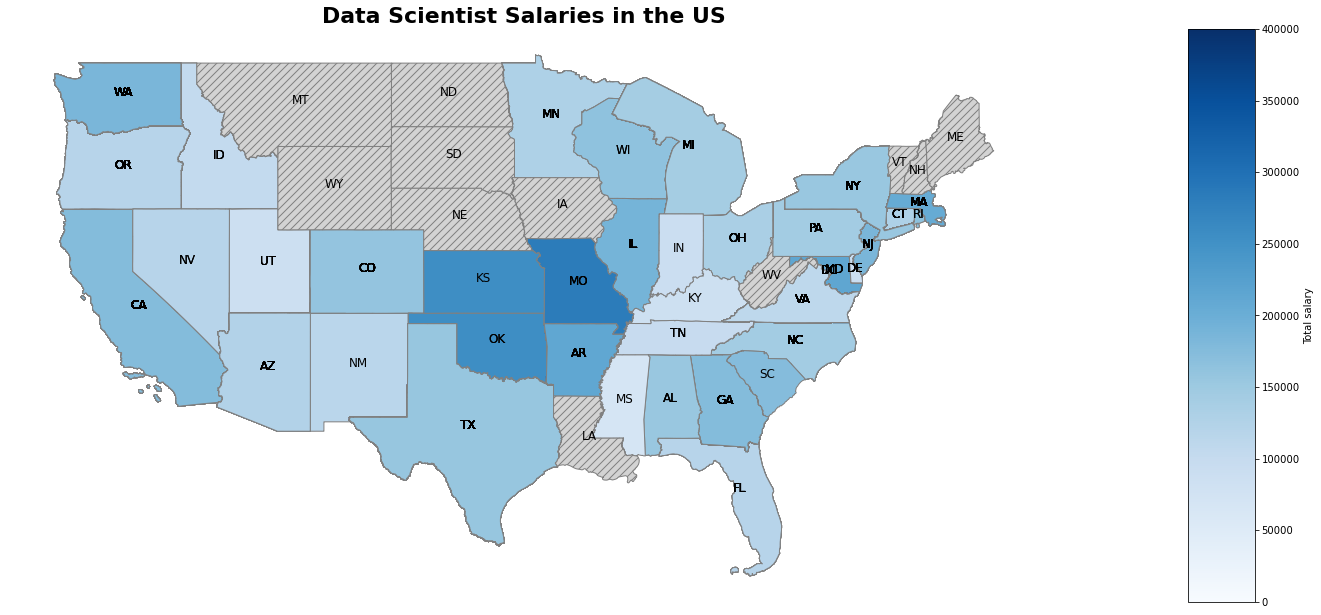

In [44]:
# Plot setup
fig, ax = plt.subplots(1, 1, figsize=[25, 15])

# Scale legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.0)

# Plot map
geo_df = geopandas.GeoDataFrame(data_usa_loc)
geo_df.plot(
    column='totalyearlycompensation',
    ax=ax,
    legend=True,
    cax=cax,
    edgecolor="grey",
    cmap="Blues", # "viridis"
    vmin=0.,
    vmax = 400000.,
    legend_kwds={"label": "Total salary", "orientation": "vertical"},
    missing_kwds={'color': 'lightgrey', "edgecolor": "grey","hatch": "///"}
    
)
geo_df.apply(lambda x: ax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=12),axis=1)
ax.set_title("Data Scientist Salaries in the US", fontweight='bold', fontsize=22)

# Plot settings
ax.axis("off")
plt.show()

#### World Map

In [45]:
#change the location to country names
data_temp = data

data_temp['location'] = np.where(data_temp['location'].str.contains("Germany"), "Germany", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("India"), "India", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Canada"), "Canada", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Switzerland"), "Switzerland", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("China"), "China", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Singapore"), "Singapore", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Israel"), "Israel", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Australia"), "Australia", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("United Kingdom"), "United Kingdom", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Taiwan"), "Taiwan", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Emirates"), "United Arab Emirates", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Sweden"), "Sweden", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Ukraine"), "Ukraine", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Japan"), "Japan", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Luxembourg"), "Luxembourg", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Russia"), "Russia", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Netherlands"), "Netherlands", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Ireland"), "Ireland", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("France"), "France", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Hong Kong"), "Hong Kong", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains("Spain"), "Spain", data_temp['location'])
data_temp['location'] = np.where(data_temp['location'].str.contains('|'.join(states), case=True), "United States of America", data_temp['location'])
data_temp['location'].unique()

array(['United States of America', 'Netherlands', 'India', 'Canada',
       'United Arab Emirates', 'Germany', 'Israel', 'Switzerland',
       'Singapore', 'United Kingdom', 'Sweden', 'Taiwan', 'China',
       'Ukraine', 'Luxembourg', 'Russia', 'Australia', 'France',
       'Ireland', 'Hong Kong', 'Spain'], dtype=object)

In [46]:
data_country = pd.DataFrame(data_temp.groupby('location').mean()['totalyearlycompensation'])
data_country = data_country.sort_values(by='totalyearlycompensation',ascending=False)
data_country.head(10)

totalyearlycompensation
location                                         
United States of America            202308.133971
Hong Kong                           180000.000000
Israel                              172818.181818
France                              171000.000000
Australia                           163250.000000
United Arab Emirates                162500.000000
Switzerland                         160857.142857
United Kingdom                      138121.951220
Singapore                           136142.857143
China                               131000.000000

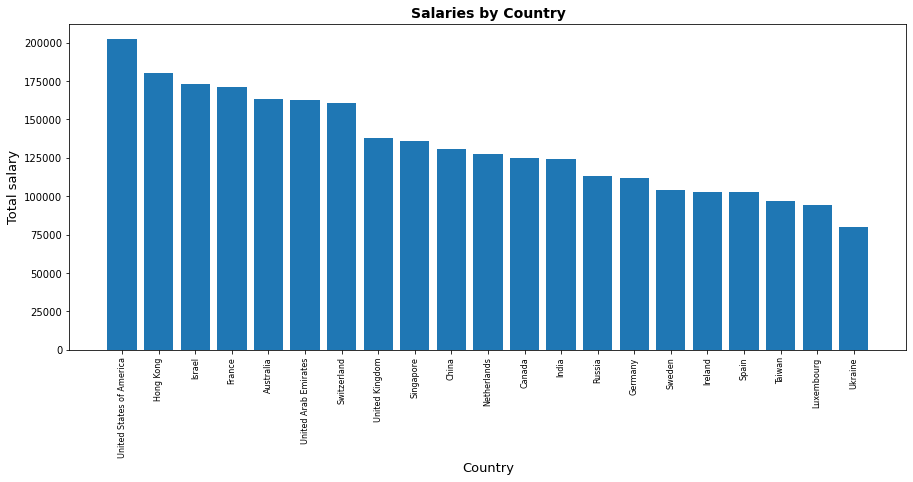

In [47]:
# check salary per country
plt.figure(figsize=(15,6))
plt.bar(data_country.index, data_country['totalyearlycompensation'])
plt.xticks(rotation='vertical', size=8)
plt.xlabel('Country', fontsize=13)
plt.ylabel('Total salary', fontsize=13)
plt.title('Salaries by Country', fontweight='bold', fontsize=14)
plt.show()

In [48]:
# download geopandas data for world
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# delete Antarctica
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[176 rows x 6 columns]

In [49]:
world.name.unique()
# Hong Kong and Singapore are missing in geographical data

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

In [50]:
data_temp

timestamp    company                        level  \
419     6/5/2018 14:06:30   LinkedIn                       Senior   
440      6/8/2018 9:49:25  Microsoft                           64   
444     6/8/2018 17:55:09       ebay                           26   
495    6/17/2018 11:39:38   Facebook                            5   
499    6/17/2018 19:02:50     Amazon                           L5   
...                   ...        ...                          ...   
62233  2/10/2019 22:46:28   Deloitte            Senior Consultant   
62240  3/26/2019 17:25:02        IBM                            8   
62283  6/17/2018 21:07:18   Facebook                           E3   
62285  7/16/2018 20:11:40        ADP           Sr UX Researcher 4   
62623  8/19/2018 20:31:37   Illumina  Bioinformatics Scientist II   

                title  totalyearlycompensation                  location  \
419    Data Scientist                   233000  United States of America   
440    Data Scientist                   218000  United States of America   
444    Data Scientist                   180000  United States of America   
495    Data Scientist                   370000  United States of America   
499    Data Scientist                   200000  United States of America   
...               ...                      ...                       ...   
62233  Data Scientist                   190000  United States of America   
62240  Data Scientist                   155000  United States of America   
62283  Data Scientist                   150000                 Singapore   
62285  Data Scientist                   185000  United States of America   
62623  Data Scientist                   175000  United States of America   

       yearsofexperience  yearsatcompany             tag     basesalary  ...  \
419                  4.0             0.0   Data Analysis  162000.000000  ...   
440                 11.0            11.0         ML / AI  165000.000000  ...   
444                 10.0             5.0       Not Given  142487.673689  ...   
495                  8.0             3.0       Not Given  190000.000000  ...   
499                  3.0             0.0         ML / AI  150000.000000  ...   
...                  ...             ...             ...            ...  ...   
62233                3.0             0.0         ML / AI  160000.000000  ...   
62240                5.0             2.0         ML / AI  141000.000000  ...   
62283                0.0             0.0         ML / AI  150000.000000  ...   
62285                8.0             2.0     UX Research  150000.000000  ...   
62623                6.0             2.0  Bioinformatics  135000.000000  ...   

       Doctorate_Degree  Highschool Some_College Race_Asian  Race_White  \
419                   0           0            0          0           0   
440                   0           0            0          0           0   
444                   0           0            0          0           0   
495                   0           0            0          0           0   
499                   0           0            0          0           0   
...                 ...         ...          ...        ...         ...   
62233                 0           0            0          0           0   
62240                 0           0            0          0           0   
62283                 0           0            0          0           0   
62285                 0           0            0          0           0   
62623                 0           0            0          0           0   

       Race_Two_Or_More  Race_Black  Race_Hispanic  Ethnicity  Education  
419                   0           0              0  Not Given  Not Given  
440                   0           0              0  Not Given  Not Given  
444                   0           0              0  Not Given  Not Given  
495                   0           0              0  Not Given  Not Given  
499                   0           0  

In [51]:
# keep only most important columns
data_world = data_temp[['totalyearlycompensation','location', 
                        'yearsofexperience', 'yearsatcompany', 'tag', 
                        'basesalary','stockgrantvalue', 'bonus']]

In [52]:
#merge data sets
data_world_geo = world.merge(data_world, how="left", left_on="name", right_on="location")
data_world_geo

pop_est      continent                 name iso_a3  gdp_md_est  \
0       920938        Oceania                 Fiji    FJI      8374.0   
1     53950935         Africa             Tanzania    TZA    150600.0   
2       603253         Africa            W. Sahara    ESH       906.5   
3     35623680  North America               Canada    CAN   1674000.0   
4     35623680  North America               Canada    CAN   1674000.0   
...        ...            ...                  ...    ...         ...   
2454   7111024         Europe               Serbia    SRB    101800.0   
2455    642550         Europe           Montenegro    MNE     10610.0   
2456   1895250         Europe               Kosovo    -99     18490.0   
2457   1218208  North America  Trinidad and Tobago    TTO     43570.0   
2458  13026129         Africa             S. Sudan    SSD     20880.0   

                                               geometry  \
0     MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1     POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2     POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3     MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4     MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
...                                                 ...   
2454  POLYGON ((18.82982 45.90887, 18.82984 45.90888...   
2455  POLYGON ((20.07070 42.58863, 19.80161 42.50009...   
2456  POLYGON ((20.59025 41.85541, 20.52295 42.21787...   
2457  POLYGON ((-61.68000 10.76000, -61.10500 10.890...   
2458  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...   

      totalyearlycompensation location  yearsofexperience  yearsatcompany  \
0                         NaN      NaN                NaN             NaN   
1                         NaN      NaN                NaN             NaN   
2                         NaN      NaN                NaN             NaN   
3                    235000.0   Canada                9.0             7.0   
4                    110000.0   Canada                3.0             3.0   
...                       ...      ...                ...             ...   
2454                      NaN      NaN                NaN             NaN   
2455                      NaN      NaN                NaN             NaN   
2456                      NaN      NaN                NaN             NaN   
2457                      NaN      NaN                NaN             NaN   
2458                      NaN      NaN                NaN             NaN   

          tag  basesalary  stockgrantvalue    bonus  
0         NaN         NaN              NaN      NaN  
1         NaN         NaN              NaN      NaN  
2         NaN         NaN              NaN      NaN  
3     ML / AI    180000.0           5000.0  50000.0  
4     ML / AI     97000.0           6000.0   7000.0  
...       ...         ...              ...      ...  
2454      NaN         NaN              NaN      NaN  
2455      NaN         NaN              NaN      NaN  
2456      NaN         NaN              NaN      NaN  
2457      NaN         NaN              NaN      NaN  
2458      NaN         NaN              NaN      NaN  

[2459 rows x 14 columns]

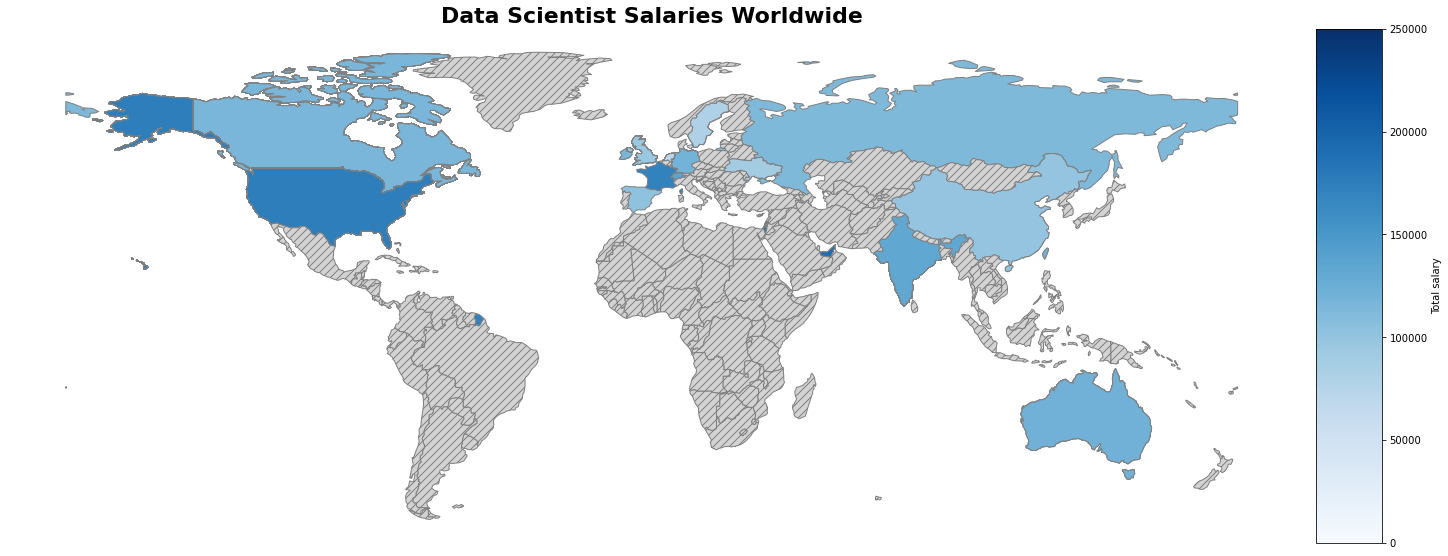

In [53]:
# Plot setup
fig, ax = plt.subplots(1, 1, figsize=[25, 15])

# Scale legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.0)

# Plot map
geo_df = geopandas.GeoDataFrame(data_world_geo)
geo_df.plot(
    column='totalyearlycompensation',
    ax=ax,
    legend=True,
    cax=cax,
    edgecolor="grey",
    cmap="Blues", # "viridis"
    vmin=0,
    vmax=250000,
    missing_kwds={'color': 'lightgrey', "edgecolor": "grey","hatch": "///"},
    legend_kwds={"label": "Total salary", "orientation": "vertical"},
)
ax.set_title("Data Scientist Salaries Worldwide", fontweight='bold', fontsize=22)

# Plot settings
ax.axis("off")
plt.show()

### Regression models

In [185]:
data_temp.head()

timestamp    company   level           title  \
419   6/5/2018 14:06:30   LinkedIn  Senior  Data Scientist   
440    6/8/2018 9:49:25  Microsoft      64  Data Scientist   
444   6/8/2018 17:55:09       ebay      26  Data Scientist   
495  6/17/2018 11:39:38   Facebook       5  Data Scientist   
499  6/17/2018 19:02:50     Amazon      L5  Data Scientist   

     totalyearlycompensation                  location  yearsofexperience  \
419                   233000  United States of America                4.0   
440                   218000  United States of America               11.0   
444                   180000  United States of America               10.0   
495                   370000  United States of America                8.0   
499                   200000  United States of America                3.0   

     yearsatcompany            tag     basesalary  ...  Doctorate_Degree  \
419             0.0  Data Analysis  162000.000000  ...                 0   
440            11.0        ML / AI  165000.000000  ...                 0   
444             5.0      Not Given  142487.673689  ...                 0   
495             3.0      Not Given  190000.000000  ...                 0   
499             0.0        ML / AI  150000.000000  ...                 0   

     Highschool Some_College Race_Asian  Race_White  Race_Two_Or_More  \
419           0            0          0           0                 0   
440           0            0          0           0                 0   
444           0            0          0           0                 0   
495           0            0          0           0                 0   
499           0            0          0           0                 0   

     Race_Black  Race_Hispanic  Ethnicity  Education  
419           0              0  Not Given  Not Given  
440           0              0  Not Given  Not Given  
444           0              0  Not Given  Not Given  
495           0              0  Not Given  Not Given  
499           0              0  Not Given  Not Given  

[5 rows x 29 columns]

In [186]:
data_temp.isnull().sum()

timestamp                  0
company                    0
level                      0
title                      0
totalyearlycompensation    0
location                   0
yearsofexperience          0
yearsatcompany             0
tag                        0
basesalary                 0
stockgrantvalue            0
bonus                      0
gender                     0
otherdetails               0
cityid                     0
dmaid                      0
rowNumber                  0
Masters_Degree             0
Bachelors_Degree           0
Doctorate_Degree           0
Highschool                 0
Some_College               0
Race_Asian                 0
Race_White                 0
Race_Two_Or_More           0
Race_Black                 0
Race_Hispanic              0
Ethnicity                  0
Education                  0
dtype: int64

In [187]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 419 to 62623
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                2325 non-null   object 
 1   company                  2325 non-null   object 
 2   level                    2325 non-null   object 
 3   title                    2325 non-null   object 
 4   totalyearlycompensation  2325 non-null   int64  
 5   location                 2325 non-null   object 
 6   yearsofexperience        2325 non-null   float64
 7   yearsatcompany           2325 non-null   float64
 8   tag                      2325 non-null   object 
 9   basesalary               2325 non-null   float64
 10  stockgrantvalue          2325 non-null   float64
 11  bonus                    2325 non-null   float64
 12  gender                   2325 non-null   object 
 13  otherdetails             2325 non-null   object 
 14  cityid               

In [188]:
# Label encoding
le = LabelEncoder()
cat_col_df = ['company','level','title','location','gender','Ethnicity','Education','timestamp']
data_corr = pd.DataFrame()
for col in cat_col_df:
    data_temp[col] = le.fit_transform(data_temp[col])

In [189]:
data['gender'].head(10)

419    1
440    1
444    0
495    1
499    1
509    1
523    1
535    1
570    2
668    2
Name: gender, dtype: int32

In [190]:
X = data_temp.drop(columns=['title', 'totalyearlycompensation', 'yearsatcompany', 'tag', 'otherdetails', 'cityid', \
                            'dmaid', 'rowNumber', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', \
                            'Some_College', 'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic'])
y = data_temp['totalyearlycompensation']
Train, Test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
X_train = Train.drop(columns='timestamp')
X_test = Test.drop(columns='timestamp') # Test is the dataframe with Timestamps retained as index for later use

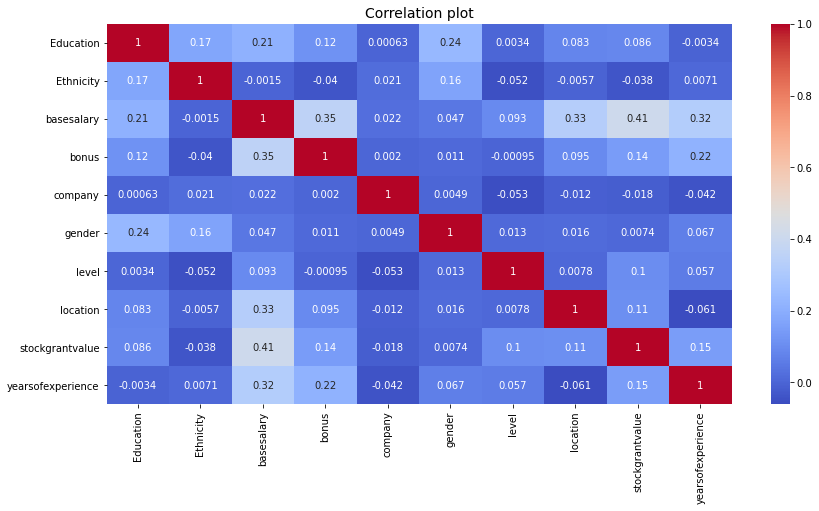

In [191]:
corr_new = X.loc[:,X.columns.difference(['timestamp'])].corr()
plt.figure(figsize=(14,7))
sns.heatmap(corr_new, annot=True, cmap='coolwarm')
plt.title("Correlation plot", fontsize=14)
plt.show()

In [192]:
def train(model, X_train, X_test, y_train, y_test):    
    # Train the model
    model.fit(X_train, y_train)
    
    # Prediction
    pred = model.predict(X_test)
    result = pd.DataFrame()
    result['index'] = Test['timestamp']
    result['Predicted Salary'] = pred
    result['Actual Salary'] = y_test
    print(result.head(10))
    
    # Cross-validation
    cv_score = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    
    print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
    print('CV Score:', np.sqrt(cv_score))
    print('R-squared value:', r2_score(y_test, pred))
    
    return result

       index  Predicted Salary  Actual Salary
13907    461     110085.352475         110000
16328    732     207408.823051         205000
46042    855     163727.295828         161000
36218    414     129381.682447         128000
52962   1342     199665.225463         197000
20633   1369     217320.727173         220000
24473   1760     206058.502547         200000
13684    554     212929.982059         211000
5367     891     189147.565568         190000
13526    406     105181.736066         104000
RMSE: 16798.854270792875
CV Score: 17078.04038110117
R-squared value: 0.9454758095773969


Text(0.5, 1.0, 'Model Coefficients (Linear Regression)')

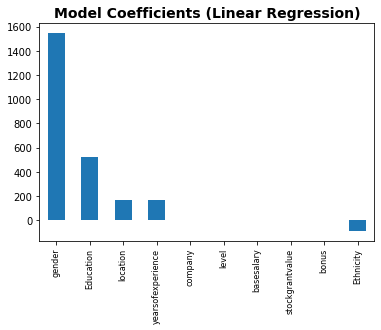

In [193]:
# Linear Regression
model_lr = LinearRegression(normalize=True)
result_lr = train(model_lr, X_train, X_test, y_train, y_test)
coef = pd.Series(model_lr.coef_, X_train.columns).sort_values(ascending=False)
coef.plot(kind='bar')
plt.xticks(rotation='vertical', size=8)
plt.title('Model Coefficients (Linear Regression)', fontweight='bold', fontsize=14)

       index  Predicted Salary  Actual Salary
13907    461          109500.0         110000
16328    732          207810.0         205000
46042    855          162680.0         161000
36218    414          126940.0         128000
52962   1342          223630.0         197000
20633   1369          222130.0         220000
24473   1760          205480.0         200000
13684    554          210450.0         211000
5367     891          190860.0         190000
13526    406          102370.0         104000
RMSE: 15996.111126472448
CV Score: 18989.71054800845
R-squared value: 0.9505622467310464


Text(0.5, 1.0, 'Feature Importance (Random Forest)')

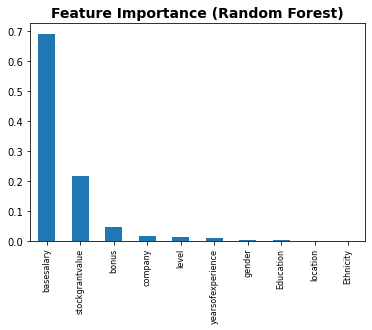

In [194]:
# Random Forest
model_rforest = RandomForestRegressor()
train(model_rforest, X_train, X_test, y_train, y_test)
coef = pd.Series(model_rforest.feature_importances_, X_train.columns).sort_values(ascending=False)
coef.plot(kind='bar')
plt.xticks(rotation='vertical', size=8)
plt.title('Feature Importance (Random Forest)', fontweight='bold', fontsize=14)

       index  Predicted Salary  Actual Salary
13907    461     109240.250000         110000
16328    732     195398.921875         205000
46042    855     158571.234375         161000
36218    414     132849.968750         128000
52962   1342     181806.562500         197000
20633   1369     218567.453125         220000
24473   1760     197672.546875         200000
13684    554     214720.687500         211000
5367     891     199046.765625         190000
13526    406     101623.406250         104000
RMSE: 16429.773421385635
CV Score: 18191.322548683835
R-squared value: 0.9478453483410743


Text(0.5, 1.0, 'Feature Importance (XGBoost)')

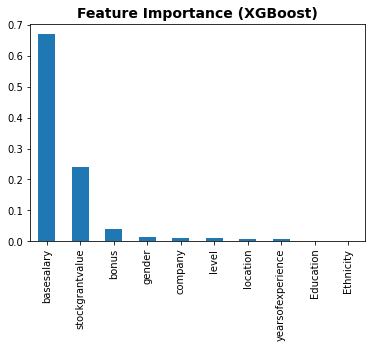

In [195]:
# XGBoost
model_xg = xgb.XGBRegressor()
train(model_xg, X_train, X_test, y_train, y_test)
coef = pd.Series(model_xg.feature_importances_, X_train.columns).sort_values(ascending=False)
coef.plot(kind='bar')
plt.title('Feature Importance (XGBoost)', fontweight='bold', fontsize=14)